# Import Modules

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import math
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn

# Read and Convert

In [88]:
df = pd.read_csv("BTC-USD.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-06-29,2567.560059,2588.830078,2510.479980,2539.320068,2539.320068,949979008
1,2017-06-30,2539.239990,2559.250000,2478.429932,2480.840088,2480.840088,860273024
2,2017-07-01,2492.600098,2515.270020,2419.229980,2434.550049,2434.550049,779913984
3,2017-07-02,2436.399902,2514.280029,2394.840088,2506.469971,2506.469971,803747008
4,2017-07-03,2498.560059,2595.000000,2480.469971,2564.060059,2564.060059,964112000


In [90]:
df1 = df.reset_index()['Close']

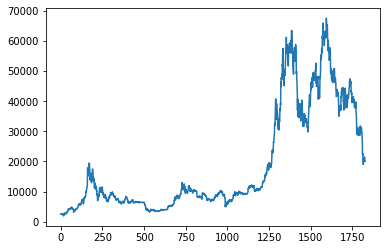

In [91]:
plt.plot(df1)

In [92]:
scaler=MinMaxScaler(feature_range=(-1,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [93]:
df1.size

1827

# Transform Train and test dataset

In [96]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.8)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [97]:
train_data.size, test_data.size

(1461, 366)

In [98]:

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [99]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [100]:
y_train.shape

(1360,)

In [101]:
X_train = np.expand_dims(X_train, axis=2)
y_train = np.expand_dims(y_train, axis=1)
X_test = np.expand_dims(X_test, axis=2)
y_test = np.expand_dims(y_test, axis=1)

In [102]:
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [103]:
y_train.size(),X_train.size()

(torch.Size([1360, 1]), torch.Size([1360, 100, 1]))

In [75]:
X_train.shape

torch.Size([716, 100, 1])

# Building model

In [104]:
# Build model
#####################
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    


In [105]:

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


# Train Model

In [106]:
# Train model
#####################
num_epochs = 100
look_back = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(X_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.11289554089307785
Epoch  20 MSE:  0.0224292054772377
Epoch  30 MSE:  0.012941851280629635
Epoch  40 MSE:  0.007713294588029385
Epoch  50 MSE:  0.004386999178677797
Epoch  60 MSE:  0.0026840984355658293
Epoch  70 MSE:  0.0018142645712941885
Epoch  80 MSE:  0.0015837199753150344
Epoch  90 MSE:  0.0014460167149081826


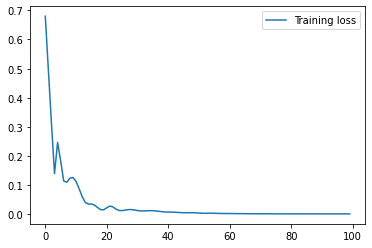

In [107]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [108]:
np.shape(y_train_pred)

torch.Size([1360, 1])

# Test Model

In [110]:
train_predict=model(X_train)
test_predict=model(X_test)

In [111]:
train_predict=scaler.inverse_transform(train_predict.detach().numpy())
test_predict=scaler.inverse_transform(test_predict.detach().numpy())

In [112]:
math.sqrt(mean_squared_error(y_train,train_predict))

19215.3205541828

In [113]:
math.sqrt(mean_squared_error(y_test,test_predict))

44804.9297287698

# Data Visuvalize

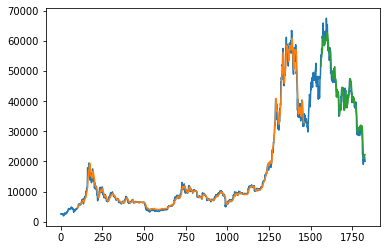

In [115]:
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Save Model

In [119]:
PATH = '/lstm.pt'
torch.save(model.state_dict(), PATH)